Strategy rules:

1. Check if today's close is in the bottom n % of the day's range
2. If condition is met then enter on the close and exit the next day's close, unless the signal is repeated

In [10]:
# import libraries
import yfinance as yf
import numpy as np
from matplotlib import pyplot as plt
import datetime
%matplotlib inline

In [11]:
# define starting variables
SYMBOL = "^GSPC"
STARTING_BALANCE = 10000
PCT_THRESH = 20

In [12]:
# define date range
START = datetime.datetime(2000, 1, 1)
END = datetime.datetime(2024, 1, 1)
YEARS = (END - START).days/ 365.25

In [13]:
# download data
price = yf.download(SYMBOL, start=START, end=END)

price.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [14]:
# drop redundant columns
price = price.drop(['Volume', 'Adj Close'], axis=1)

price.tail()

,Open,High,Low,Close
Date,,,,
2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000
2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078
2023-12-28,4786.439941,4793.299805,4780.979980,4783.350098
2023-12-29,4782.879883,4788.430176,4751.990234,4769.830078


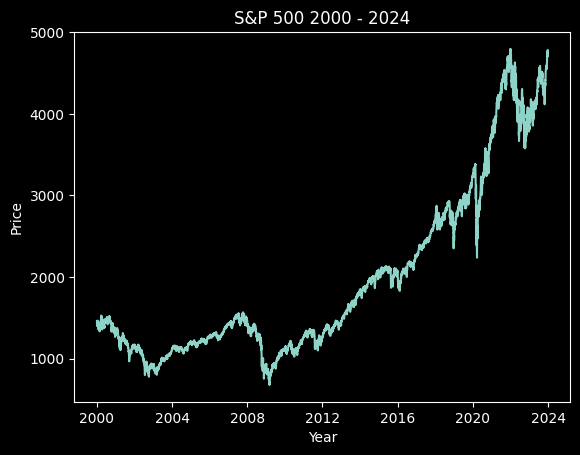

In [15]:
# plot chart
plt.style.use('dark_background')
plt.plot(price.Close)

plt.title('S&P 500 2000 - 2024')
plt.xlabel('Year')
plt.ylabel('Price')

plt.show()

# Calculating Benchmark Return and Balance

In this section, we compute the benchmark return and track the cumulative balance over time, starting with a predefined balance (`STARTING_BALANCE`).

1. **Benchmark Return Calculation**: 
   - We calculate the daily return as the ratio of the current day's closing price to the previous day's closing price. The first day's return is manually set to 1 to avoid a NaN value.

2. **Cumulative Balance**: 
   - The cumulative balance is determined by multiplying the starting balance by the cumulative product of the daily returns. This allows us to simulate how an initial investment would grow (or shrink) over time based on daily returns.


In [16]:
# calculate benchmark return and balance
price['Return'] = price.Close / price.Close.shift(1)
price.Return.iat[0] = 1
price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()

price.tail()

,Open,High,Low,Close,Return,Bench_Bal
Date,,,,,,
2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883,1.001660,32672.929032
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000,1.004232,32811.190721
2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078,1.001430,32858.125743
2023-12-28,4786.439941,4793.299805,4780.979980,4783.350098,1.000370,32870.288987
2023-12-29,4782.879883,4788.430176,4751.990234,4769.830078,0.997174,32777.381936


# Calculating Benchmark Drawdown

In this section, we calculate the drawdown for the benchmark, which helps in assessing the peak-to-trough decline in the cumulative balance over time.

1. **Peak Balance Calculation**: 
   - `price['Bench_Peak'] = price.Bench_Bal.cummax()` computes the highest cumulative balance (`Bench_Bal`) reached at any given point in time, using the cumulative maximum function (`cummax()`).

2. **Drawdown Calculation**: 
   - `price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak` calculates the drawdown by subtracting the peak balance from the current balance. This gives the decline from the peak.

3. **Maximum Drawdown as a Percentage**: 
   - `bench_dd = round(((price.Bench_DD / price.Bench_Peak).min() * 100), 2)` finds the maximum drawdown as a percentage by dividing the drawdown by the peak balance, and then rounding it to two decimal places.

4. **Display Maximum Drawdown**: 
   - `bench_dd` holds the value of the maximum drawdown expressed as a percentage.

In [17]:
# calculate benchmark drawdown
price['Bench_Peak'] = price.Bench_Bal.cummax()
price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

bench_dd = round(((price.Bench_DD / price.Bench_Peak).min() * 100), 2)

bench_dd

-56.78

# Calculating Additional Columns for the Strategy

In this section, we calculate key columns that are essential for the back testing by assessing the daily price range and the position of the closing price relative to the daily low.

1. **Daily Range Calculation**: 
   - `price['Range'] = price.High - price.Low` computes the daily price range as the difference between the high and low prices of the day.

2. **Distance from Close to Low**: 
   - `price['Dist'] = abs(price.Close - price.Low)` calculates the absolute distance between the closing price and the daily low price.

3. **Distance as Percentage of Range**: 
   - `price['Pct'] = (price.Dist / price.Range) * 100` expresses the distance from the close to the low as a percentage of the daily range.

In [29]:
# calculate additional columns for strategy

# daily range
price['Range'] = price.High - price.Low
# distance between close and daily low
price['Dist'] = abs(price.Close - price.Low)
# distance as % of range
price['Pct'] = (price.Dist / price.Range) * 100

price.tail()

,Open,High,Low,Close,Return,Bench_Bal,Bench_Peak,Bench_DD,Range,Dist,Pct,Long
Date,,,,,,,,,,,,
2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883,1.001660,32672.929032,32961.065373,-288.136341,36.169922,17.859863,49.377666,False
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000,1.004232,32811.190721,32961.065373,-149.874651,26.270020,16.299805,62.047174,False
2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078,1.001430,32858.125743,32961.065373,-102.939630,16.490234,12.680176,76.895061,False
2023-12-28,4786.439941,4793.299805,4780.979980,4783.350098,1.000370,32870.288987,32961.065373,-90.776386,12.319824,2.370117,19.238239,True
2023-12-29,4782.879883,4788.430176,4751.990234,4769.830078,0.997174,32777.381936,32961.065373,-183.683436,36.439941,17.839844,48.956840,False


In [30]:
# identify entries and allocate trading fees
price['Long'] = np.logical_and((price.Pct < PCT_THRESH), (price.Range > 10))

# Calculating System Return and Balance

In this section, we calculate the system's return and track the cumulative balance over time, starting with the defined initial balance (`STARTING_BALANCE`).

1. **System Return Calculation**: 
   - `price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)` computes the system's daily return. If a long position was held the previous day (`price.Long.shift(1) == True`), the return is taken from the `Return` column. If no position was held, the return is set to 1 (indicating no gain or loss for that day).

2. **Cumulative System Balance**: 
   - `price['Sys_Bal'] = (STARTING_BALANCE * price.Sys_Ret.cumprod())` calculates the cumulative system balance by multiplying the starting balance by the cumulative product of the system's daily returns. This reflects how the system's balance changes over time based on the strategy's returns.


In [31]:
# calculate system return and balance
price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)
price['Sys_Bal'] = (STARTING_BALANCE * price.Sys_Ret.cumprod())

price.tail()

,Open,High,Low,Close,Return,Bench_Bal,Bench_Peak,Bench_DD,Range,Dist,Pct,Long,Sys_Ret,Sys_Bal
Date,,,,,,,,,,,,,,
2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883,1.001660,32672.929032,32961.065373,-288.136341,36.169922,17.859863,49.377666,False,1.000000,60316.607377
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000,1.004232,32811.190721,32961.065373,-149.874651,26.270020,16.299805,62.047174,False,1.000000,60316.607377
2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078,1.001430,32858.125743,32961.065373,-102.939630,16.490234,12.680176,76.895061,False,1.000000,60316.607377
2023-12-28,4786.439941,4793.299805,4780.979980,4783.350098,1.000370,32870.288987,32961.065373,-90.776386,12.319824,2.370117,19.238239,True,1.000000,60316.607377
2023-12-29,4782.879883,4788.430176,4751.990234,4769.830078,0.997174,32777.381936,32961.065373,-183.683436,36.439941,17.839844,48.956840,False,0.997174,60146.123993


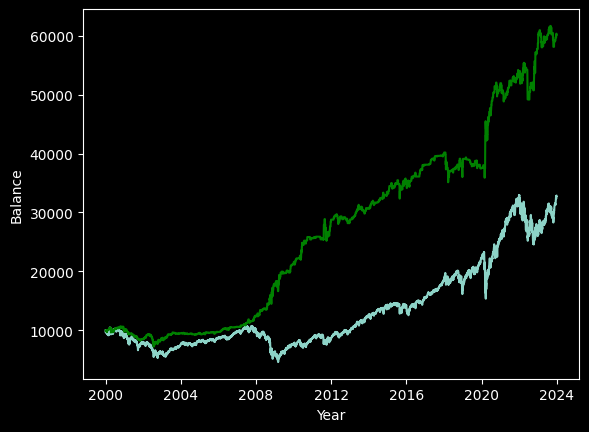

In [32]:
# plot balance
plt.plot(price.Bench_Bal)
plt.plot(price.Sys_Bal, color="g")

plt.xlabel('Year')
plt.ylabel('Balance')

plt.show()

In [33]:
# calculate system drawdown
price['Sys_Peak'] = price.Sys_Bal.cummax()
price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak

sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)

sys_dd

-32.29

# Calculating Performance Metrics

We calculate key performance metrics for both the benchmark and the trading system, including total return, Compound Annual Growth Rate (CAGR), drawdown, time in the market, and win rate. These metrics provide a comprehensive comparison between the two approaches.

The results reveal that the system significantly outperformed the benchmark, with a total return of 501.46% compared to 227.7% for the benchmark. Additionally, the system offered better capital protection, with a smaller drawdown of -32.29% versus the benchmark’s -56.78%.

One notable observation is the system's efficiency, as it was only invested 19% of the time, yet still achieved superior results.

In [35]:
#calculate metrics
bench_return = round(((price.Bench_Bal.iloc[-1]/price.Bench_Bal.iloc[0]) - 1) * 100, 2)
bench_cagr = round(((((price.Bench_Bal.iloc[-1]/price.Bench_Bal.iloc[0])**(1/YEARS))-1)*100), 2)
sys_return = round(((price.Sys_Bal.iloc[-1]/price.Sys_Bal.iloc[0]) - 1) * 100, 2)
sys_cagr = round(((((price.Sys_Bal.iloc[-1]/price.Sys_Bal.iloc[0])**(1/YEARS))-1)*100), 2)
sys_in_market = round((price.Long.value_counts().loc[True] / len(price)) * 100)
sys_win = price.Sys_Ret[price.Sys_Ret > 1.0].count()
sys_loss = price.Sys_Ret[price.Sys_Ret < 1.0].count()
sys_winrate = round(sys_win / (sys_win + sys_loss) * 100, 2)

print(f'Benchmark Total return: {bench_return}%')
print(f'Benchmark CAGR: {bench_cagr}')
print(f'Benchmark DD: {bench_dd}%')
print('')
print(f'System Total return: {sys_return}%')
print(f'System CAGR: {sys_cagr}')
print(f'System DD: {sys_dd}%')
print(f'Time in Market: {sys_in_market}%')
print(f'Trades Won: {sys_win}')
print(f'Trades Loss: {sys_loss}')
print(f'Winrate: {sys_winrate}%')

Benchmark Total return: 227.77%
Benchmark CAGR: 5.07
Benchmark DD: -56.78%

System Total return: 501.46%
System CAGR: 7.76
System DD: -32.29%
Time in Market: 19%
Trades Won: 677
Trades Loss: 489
Winrate: 58.06%


# Comparing with Other Indices

In this section, we extend the strategy comparison to other indices over the same period. 

The `backtest` function is created that allows us to input the symbol of a specific index, enabling the calculation of performance metrics for each one.

In [36]:
#define list of ETFs to backtest
symbols = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^N225']

In [37]:
#create backtesting function
def backtest(s):
    #download data
    price = yf.download(s, start=START, end=END)
    
    #drop redundant columns
    price = price.drop(['Volume', 'Adj Close'], axis=1)
    
    #calculate benchmark return and balance
    price['Return'] = price.Close / price.Close.shift(1)
    price.Return.iat[0] = 1
    price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()
    
    #calculate benchmark drawdown
    price['Bench_Peak'] = price.Bench_Bal.cummax()
    price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak
    
    #calculate additional columns for strategy
    #daily range
    price['Range'] = price.High - price.Low
    #distance between close and daily low
    price['Dist'] = abs(price.Close - price.Low)
    #distance as % of range
    price['Pct'] = (price.Dist / price.Range) * 100
    
    #identify entries and allocate trading fees
    price['Long'] = np.logical_and((price.Pct < PCT_THRESH), (price.Range > 10))
    
    #calculate system return and balance
    price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)
    price['Sys_Bal'] = (STARTING_BALANCE * price.Sys_Ret.cumprod())
    
    #calculate system drawdown
    price['Sys_Peak'] = price.Sys_Bal.cummax()
    price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak
    
    #calculate metrics
    bench_cagr = round(((((price.Bench_Bal.iloc[-1]/price.Bench_Bal.iloc[0])**(1/YEARS))-1)*100), 2)
    bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
    sys_cagr = round(((((price.Sys_Bal.iloc[-1]/price.Sys_Bal.iloc[0])**(1/YEARS))-1)*100), 2)
    sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)
    
    return bench_cagr, sys_cagr

In [38]:
#backtest multiple symbols
bc = []
sc = []


for symbol in symbols:
    bench_cagr, sys_cagr = backtest(symbol)
    bc.append(bench_cagr)
    sc.append(sys_cagr)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


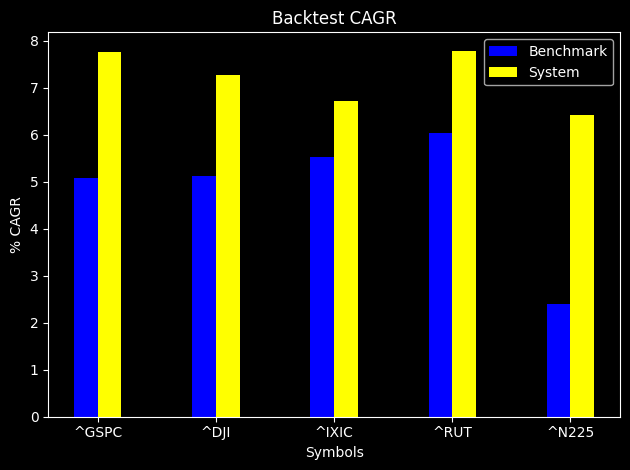

In [39]:
#plot data
x_indices = np.arange(len(symbols))
width = 0.2

plt.bar(x_indices - width / 2, bc, width = width, label = 'Benchmark', color="blue")
plt.bar(x_indices + width / 2, sc, width = width, label = 'System', color="yellow")
   
plt.xticks(ticks = x_indices, labels = symbols)

plt.legend()

plt.title('Backtest CAGR')
plt.xlabel('Symbols')
plt.ylabel('% CAGR')
plt.tight_layout()

plt.show()

# Conclusion

The backtesting results demonstrate that the "buy the dip" strategy tends to outperform the benchmark across multiple markets.

While this analysis does not account for factors such as fees, FX rates, and other variables that could affect the final balance, it is noteworthy that the strategy delivers better returns over the long term when compared to the benchmark.